In [19]:
import cv2
import os
from ultralytics import YOLO

# === 全域變數 (避免在函式內用 global) ===
drawing = False
start_point = (-1, -1)
boxes = []         # 當前影格標註框列表
frame_copy = None  # 用於顯示及繪製
yolo_boxes = []    # YOLO 預測的標註框

def on_mouse(event, x, y, flags, param):
    """
    滑鼠事件回呼函式，用於框選邊界框。
    按下左鍵開始、鬆開左鍵完成框選。
    """
    global drawing, start_point, boxes, frame_copy

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            # 實時更新畫面顯示
            frame_copy_temp = frame_copy.copy()
            # 繪製已有的 YOLO 框
            for bbox in boxes:
                x_min, y_min, w, h = bbox
                cv2.rectangle(frame_copy_temp, (x_min, y_min), (x_min + w, y_min + h), (0, 255, 0), 2)
            # 繪製新的框選
            cv2.rectangle(frame_copy_temp, start_point, (x, y), (255, 0, 0), 2)
            cv2.imshow("Annotation Tool", frame_copy_temp)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        end_point = (x, y)
        x_min, x_max = min(start_point[0], end_point[0]), max(start_point[0], end_point[0])
        y_min, y_max = min(start_point[1], end_point[1]), max(start_point[1], end_point[1])

        # 將 (x_min, y_min, w, h) 存入
        boxes.append((x_min, y_min, x_max - x_min, y_max - y_min))

        # 繪製最終框
        cv2.rectangle(frame_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.imshow("Annotation Tool", frame_copy)

def annotate_video(video_path, output_dir='labels', max_frames=None, yolo_model='yolov8n.pt'):
    """
    使用 YOLO 進行初始標註，然後允許使用者刪除或手動標註。
    使用者可視需要設定 max_frames 以限制標註幀數，
    或保留 None 讓程式跑完整部影片。
    """
    # 建立輸出標註資料夾
    os.makedirs(output_dir, exist_ok=True)

    # 加載 YOLO 模型
    model = YOLO(yolo_model)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: 無法開啟影片 {video_path}")
        return

    frame_index = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames is None or max_frames > total_frames:
        max_frames = total_frames

    print(f"開始標註: {video_path}")
    print(f"總幀數: {total_frames}, 設定標註幀數: {max_frames}")

    global boxes, frame_copy, yolo_boxes  # 使用全域變數儲存當前影格的標註框

    while frame_index < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        boxes = []  # 重設當前幀的手動標註框
        yolo_boxes = [] # 重設當前幀的 YOLO 標註框
        frame_copy = frame.copy()

        # 使用 YOLO 進行預測
        results = model.predict(frame, verbose=False, conf=0.7)
        if results and results[0].boxes:
            for box in results[0].boxes:
                x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
                w = x_max - x_min
                h = y_max - y_min
                yolo_boxes.append((x_min, y_min, w, h))
                # 初始顯示 YOLO 預測框 (綠色)
                cv2.rectangle(frame_copy, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                boxes.append((x_min, y_min, w, h)) # 將 YOLO 結果加入初始 boxes

        # 設定並顯示視窗
        cv2.namedWindow("Annotation Tool", cv2.WINDOW_AUTOSIZE)
        # 調整視窗大小 (選擇性)
        #cv2.resizeWindow("Annotation Tool", 1280, 720)

        cv2.setMouseCallback("Annotation Tool", on_mouse)
        cv2.imshow("Annotation Tool", frame_copy)

        while True:
            key = cv2.waitKey(1) & 0xFF
            #rint(f"[INFO] 當前幀: {frame_index}, 按鍵: {key}")
            if key == ord('s'):
                # 儲存標註到 txt
                print(f"[INFO] 儲存第 {frame_index} 幀標註...")
                label_path = os.path.join(output_dir, f"frame_{frame_index:04d}.txt")
                with open(label_path, 'w') as f:
                    for (x, y, w, h) in boxes:
                        f.write(f"{x},{y},{w},{h}\n")
                print(f"[INFO] 第 {frame_index} 幀標註已儲存: {label_path}")
                break

            elif key == ord('d'):
                # 刪除最後一個手動標註框
                if boxes:
                    boxes.pop()
                    frame_copy = frame.copy()
                    # 重新繪製剩餘的框
                    for bbox in boxes:
                        x_min, y_min, w, h = bbox
                        cv2.rectangle(frame_copy, (x_min, y_min), (x_min + w, y_min + h), (255, 0, 0), 2)
                    cv2.imshow("Annotation Tool", frame_copy)
                    print("[INFO] 上一個標註框已刪除.")
                else:
                    print("[INFO] 沒有可以刪除的標註框.")

            elif key == ord('r'):
                # 重設此幀所有標註框 (包括 YOLO 預測)
                boxes = []
                frame_copy = frame.copy()
                # 重新繪製 YOLO 預測框
                for x_min, y_min, w, h in yolo_boxes:
                    cv2.rectangle(frame_copy, (x_min, y_min), (x_min + w, y_min + h), (0, 255, 0), 2)
                cv2.imshow("Annotation Tool", frame_copy)
                print("[INFO] 當前影格標註已重置 (包括 YOLO 預測).")

            elif key == ord('q'):
                # 跳過此幀，不存檔
                print(f"[INFO] 跳過第 {frame_index} 幀 (未儲存標註)")
                break

        frame_index += 1

    cap.release()
    cv2.destroyAllWindows()
    print("標註作業完成！")

if __name__ == "__main__":
    video_path = r"E:\論文\期刊\code\Detection_EXP\video2\test5_240fps_input.mp4"  # 影片路徑
    output_dir = r'E:\論文\期刊\code\指標\video2\ground_true_YOLO'
    yolo_model_path = r"E:\論文\期刊\code\YOLO\satellite3_train.pt"  # 可以替換成 'yolov8m.pt' 或其他 YOLO 模型

    annotate_video(video_path, output_dir=output_dir, yolo_model=yolo_model_path)

開始標註: E:\論文\期刊\code\Detection_EXP\video2\test5_240fps_input.mp4
總幀數: 60, 設定標註幀數: 60
[INFO] 儲存第 0 幀標註...
[INFO] 第 0 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0000.txt
[INFO] 儲存第 1 幀標註...
[INFO] 第 1 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0001.txt
[INFO] 儲存第 2 幀標註...
[INFO] 第 2 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0002.txt
[INFO] 儲存第 3 幀標註...
[INFO] 第 3 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0003.txt
[INFO] 儲存第 4 幀標註...
[INFO] 第 4 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0004.txt
[INFO] 儲存第 5 幀標註...
[INFO] 第 5 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0005.txt
[INFO] 儲存第 6 幀標註...
[INFO] 第 6 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0006.txt
[INFO] 儲存第 7 幀標註...
[INFO] 第 7 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0007.txt
[INFO] 儲存第 8 幀標註...
[INFO] 第 8 幀標註已儲存: E:\論文\期刊\code\指標\video2\ground_true_YOLO\frame_0008.txt
[INFO] 儲存第 9 幀標註...
[INFO] 第 9 幀標註已儲存: E:\論文\期刊\code\指標\video

In [10]:
import cv2
import sys
import os

def get_video_properties(video_path):
    """
    讀取並印出影片的屬性。

    Args:
        video_path (str): 影片檔案的路徑。
    """
    # 檢查檔案是否存在
    if not os.path.exists(video_path):
        print(f"錯誤：找不到檔案 '{video_path}'")
        return

    # 開啟影片檔案
    cap = cv2.VideoCapture(video_path)

    # 檢查是否成功開啟
    if not cap.isOpened():
        print(f"錯誤：無法開啟影片檔案 '{video_path}'")
        return

    # --- 獲取影片屬性 ---
    # 寬度 (pixels)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    # 高度 (pixels)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # 幀率 (Frames Per Second - FPS)
    fps = cap.get(cv2.CAP_PROP_FPS)
    # 總幀數
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # 編碼器 FourCC 碼 (需要解碼)
    fourcc_int = int(cap.get(cv2.CAP_PROP_FOURCC))

    # --- 計算與解碼 ---
    # 計算影片長度 (秒)
    duration_sec = 0
    if fps > 0 and frame_count > 0:
        duration_sec = frame_count / fps
    else:
        # 有些影片可能無法直接讀取幀數或 FPS
        duration_sec = -1

    # 解碼 FourCC (影片編碼格式)
    # 將整數轉換為 4 個字元的編碼名稱
    try:
        fourcc = "".join([chr((fourcc_int >> 8 * i) & 0xFF) for i in range(4)])
    except Exception:
        fourcc = f"無法解碼 ({fourcc_int})"


    # --- 印出結果 ---
    print(f"--- 影片屬性 ---")
    print(f"檔案路徑: {video_path}")
    print(f"解析度  : {width} x {height} pixels")
    print(f"幀率 (FPS): {fps:.2f}") # 印到小數點後兩位
    print(f"總幀數  : {frame_count}")
    print(f"編碼格式: {fourcc}")

    if duration_sec >= 0:
        minutes = int(duration_sec // 60)
        seconds = duration_sec % 60
        print(f"影片長度: {duration_sec:.2f} 秒 (~ {minutes} 分 {seconds:.2f} 秒)")
    else:
        print("影片長度: 無法計算 (可能缺少 FPS 或總幀數資訊)")

    # 釋放資源
    cap.release()

# --- 主程式 ---
if __name__ == "__main__":
    # 方法一：直接在程式碼中指定影片路徑
    video_file = r"E:/論文/期刊/code/指標/video0/aligned_video2.mp4" # <--- 在這裡修改成你的影片路徑

    get_video_properties(video_file)


--- 影片屬性 ---
檔案路徑: E:/論文/期刊/code/指標/video0/aligned_video2.mp4
解析度  : 2098 x 1178 pixels
幀率 (FPS): 15.00
總幀數  : 60
編碼格式: FMP4
影片長度: 4.00 秒 (~ 0 分 4.00 秒)


In [ ]:
import cv2
import os

# === 全域變數 (避免在函式內用 global) ===
drawing = False
start_point = (-1, -1)
boxes = []         # 當前影格標註框列表
frame_copy = None  # 用於顯示及繪製

def on_mouse(event, x, y, flags, param):
    """
    滑鼠事件回呼函式，用於框選邊界框。
    按下左鍵開始、鬆開左鍵完成框選。
    """
    global drawing, start_point, boxes, frame_copy

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            # 實時更新畫面顯示
            frame_copy_temp = frame_copy.copy()
            cv2.rectangle(frame_copy_temp, start_point, (x, y), (255, 0, 0), 2)
            cv2.imshow("Annotation Tool", frame_copy_temp)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        end_point = (x, y)
        x_min, x_max = min(start_point[0], end_point[0]), max(start_point[0], end_point[0])
        y_min, y_max = min(start_point[1], end_point[1]), max(start_point[1], end_point[1])
        
        # 將 (x_min, y_min, w, h) 存入
        boxes.append((x_min, y_min, x_max - x_min, y_max - y_min))
        
        # 繪製最終框
        cv2.rectangle(frame_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.imshow("Annotation Tool", frame_copy)

def annotate_video(video_path, output_dir='labels', max_frames=None):
    """
    使用者可視需要設定 max_frames 以限制標註幀數，
    或保留 None 讓程式跑完整部影片。
    """
    # 建立輸出標註資料夾
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: 無法開啟影片 {video_path}")
        return

    frame_index = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames is None or max_frames > total_frames:
        max_frames = total_frames

    print(f"開始標註: {video_path}")
    print(f"總幀數: {total_frames}, 設定標註幀數: {max_frames}")

    global boxes, frame_copy  # 使用全域變數儲存當前影格的標註框

    while frame_index < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        boxes = []  # 重設當前幀的標註框
        frame_copy = frame.copy()

        # 設定並顯示視窗
        cv2.namedWindow("Annotation Tool", cv2.WINDOW_AUTOSIZE)
        # 調整視窗大小 (選擇性)
        #cv2.resizeWindow("Annotation Tool", 1280, 720)

        cv2.setMouseCallback("Annotation Tool", on_mouse)
        cv2.imshow("Annotation Tool", frame)

        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('s'):
                # 儲存標註到 txt
                label_path = os.path.join(output_dir, f"frame_{frame_index:04d}.txt")
                with open(label_path, 'w') as f:
                    for (x, y, w, h) in boxes:
                        f.write(f"{x},{y},{w},{h}\n")
                print(f"[INFO] 第 {frame_index} 幀標註已儲存: {label_path}")
                break

            elif key == ord('r'):
                # 重設此幀所有標註框
                boxes = []
                frame_copy = frame.copy()
                cv2.imshow("Annotation Tool", frame_copy)
                print("[INFO] 當前影格標註已重置.")

            elif key == ord('q'):
                # 跳過此幀，不存檔
                print(f"[INFO] 跳過第 {frame_index} 幀 (未儲存標註)")
                break

        frame_index += 1

    cap.release()
    cv2.destroyAllWindows()
    print("標註作業完成！")

if __name__ == "__main__":
    video_path = r"E:\論文\期刊\code\指標\video0\aligned_video2.mp4"   # 影片路徑
    annotate_video(video_path, output_dir=r'E:\論文\期刊\code\指標\video0\ground_true')


開始標註: E:\論文\期刊\code\指標\video0\aligned_video2.mp4
總幀數: 60, 設定標註幀數: 60


KeyboardInterrupt: 

: 

In [13]:
import os

def unify_format(src_folder, dst_folder, delimiter_in, delimiter_out):
    """
    將 src_folder 底下的 txt 檔，每行的 bounding box 從 delimiter_in 分隔格式
    轉換成 delimiter_out 分隔格式，並輸出到 dst_folder。
    
    :param src_folder: 來源資料夾路徑
    :param dst_folder: 輸出資料夾路徑
    :param delimiter_in: 原檔案的分隔符 (例如 ',' or ' ')
    :param delimiter_out: 輸出檔案的分隔符 (例如 ',' or ' ')
    """
    os.makedirs(dst_folder, exist_ok=True)
    
    for filename in os.listdir(src_folder):
        if not filename.endswith(".txt"):
            continue
        
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, filename)
        
        with open(src_path, 'r', encoding='utf-8') as f_in, \
             open(dst_path, 'w', encoding='utf-8') as f_out:
            
            for line in f_in:
                line = line.strip()
                if not line:
                    continue
                # 根據原先的分隔符來 split
                fields = line.split(delimiter_in)
                
                # 去除空字串(有時 split 出來會有多餘空白)
                fields = [item.strip() for item in fields if item.strip()]
                
                # 轉成指定的輸出格式
                output_line = delimiter_out.join(fields)
                
                f_out.write(output_line + "\n")


if __name__ == "__main__":
    base_dir = r"E:\論文\期刊\code\指標\video2"  # 你的專案根目錄 (可自行調整)
    
    # 1) 處理 detections 資料夾 (原本是空白分隔 -> 統一成「逗號分隔」)
    src_detections = os.path.join(base_dir, "detections")
    dst_detections = os.path.join(base_dir, "detections_unified")
    
    unify_format(
        src_folder=src_detections,
        dst_folder=dst_detections,
        delimiter_in=' ',    # 原始為空白
        delimiter_out=','    # 統一成逗號
    )
    
    # 2) 處理 ground_true 資料夾 (原本是逗號分隔 -> 統一成「逗號分隔」)
    #   若它本來就是逗號，也想確保格式一致，仍可再跑一遍 (去除多餘空白等)
    src_ground_true = os.path.join(base_dir, "ground_true")
    dst_ground_true = os.path.join(base_dir, "ground_true_unified")
    
    unify_format(
        src_folder=src_ground_true,
        dst_folder=dst_ground_true,
        delimiter_in=',',   # 原始為逗號
        delimiter_out=','   # 統一還是逗號
    )
    
    print("格式統一完成!")


格式統一完成!


In [24]:
import os
import cv2
import time

def parse_bboxes(txt_file_path, delimiter=','):
    """
    讀取給定的 txt 檔，假設格式為每行 'x<delimiter>y<delimiter>w<delimiter>h'
    轉成 [(x, y, w, h), ...] 的列表
    """
    bboxes = []
    if not os.path.isfile(txt_file_path):
        return bboxes  # 若檔案不存在，就回傳空
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(delimiter)
            if len(parts) != 4:
                continue
            x, y, w, h = [int(float(val)) for val in parts]
            bboxes.append((x, y, w, h))
    return bboxes

def draw_bboxes(frame, bboxes, color, thickness=2):
    """
    在 frame 上畫出 bboxes，顏色 color 為 (B, G, R) format
    """
    for (x, y, w, h) in bboxes:
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, thickness)

def inspect_video_and_boxes(
    video_path,
    det_folder,
    gt_folder,
    output_folder=None,    # 若想將可視化結果存檔，指定資料夾路徑；若為 None 就不存檔
    delimiter=',',
    interval_sec=0.0001
):
    """
    每 0.1 秒（或自訂 interval_sec）擷取影片影格，畫出對應的 'detections' 與 'ground_true' 框。
    
    :param video_path:      影片路徑
    :param det_folder:      預測框所在資料夾 (已是 x,y,w,h 格式, 用 delimiter 分隔)
    :param gt_folder:       真值框所在資料夾 (已是 x,y,w,h 格式, 用 delimiter 分隔)
    :param output_folder:   若指定，將每個擷取到的影格(含框)存成一張圖片
    :param delimiter:       文字檔內的分隔符號(預設為 ',')
    :param interval_sec:    每幾秒擷取一次影格 (預設 0.1 秒)
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"無法打開影片: {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        # 若無法讀取到有效 fps，就假設 30
        fps = 30.0
    print(f"Video FPS: {fps}")
    
    # 每次要跳過的影格數
    frames_to_skip = 1
    if frames_to_skip < 1:
        frames_to_skip = 1  # 保證至少每一影格都會處理
    
    # 如果要存圖，就建立資料夾
    if output_folder is not None:
        os.makedirs(output_folder, exist_ok=True)
    
    frame_index = 0       # 影片實際的 frame 編號(從 0 起)
    saved_index = 0       # 記錄我們已經處理(顯示/存圖)的第幾個擷取點
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # 只處理符合 "取樣" 的影格 (亦即每隔 frames_to_skip 就處理一次)
        # 例如 frame_index = 0, 3, 6, 9... (若 frames_to_skip=3)
        if frame_index % frames_to_skip == 0:
            # --- 1) 推算對應檔名 ---
            # 假設 detections 檔名是 "detections_00000.txt"
            # ground_true 檔名是 "frame_0000.txt"
            # 你可自行在這裡做字串處理以對應你的實際檔名

            # 先做 int->字串 => "00000"
            det_file_id = f"{frame_index-1:04d}"  # 5 位數
            det_txt_name = f"detections_{det_file_id}.txt"
            det_txt_path = os.path.join(det_folder, det_txt_name)

            # ground truth 檔名 => "frame_0000"
            # 取 frame_index => "0000" (4 位數)
            gt_file_id = f"{frame_index:04d}"
            gt_txt_name = f"frame_{gt_file_id}.txt"
            gt_txt_path = os.path.join(gt_folder, gt_txt_name)

            # --- 2) 讀取框 ---
            det_bboxes = parse_bboxes(det_txt_path, delimiter=delimiter)
            gt_bboxes  = parse_bboxes(gt_txt_path, delimiter=delimiter)

            # --- 3) 在當前影格上畫出框 ---
            # 預測框(藍色), 真值框(綠色) => 你可自行變更顏色
            draw_bboxes(frame, det_bboxes, color=(255, 0, 0))   # BGR (藍)
            draw_bboxes(frame, gt_bboxes,  color=(0, 255, 0))   # (綠)

            # --- 4) 顯示或存檔 ---
            cv2.imshow("Pred & GT Boxes", frame)

            if output_folder:
                out_name = f"frame_{frame_index:04d}.jpg"
                out_path = os.path.join(output_folder, out_name)
                cv2.imwrite(out_path, frame)
            
            saved_index += 1

            # 按 'q' 可退出
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        frame_index += 1
        time.sleep(0.1)  # 暫停一下，模擬慢速播放

    cap.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    base_dir = r"E:\論文\期刊\code\Detection_EXP\video2"  # 你的資料夾根目錄
    
    video_file = os.path.join(base_dir, "test5_240fps_input.mp4")
    
    # 假設你有:
    #  video0/detections/  (ex: detections_0000.txt)
    #  video0/ground_true/ (ex: frame_0000.txt)
    det_folder = os.path.join(base_dir, "detections2")
    gt_folder  = os.path.join(base_dir, "ground_true_YOLO")

    # 若你想把畫完框的影格輸出到 "frames_out" 資料夾
    # 改成 None 就不會存檔
    output_folder = os.path.join(base_dir, "frames_out")

    inspect_video_and_boxes(
        video_path=video_file,
        det_folder=det_folder,
        gt_folder=gt_folder,
        output_folder=output_folder,   # 若不要輸出檔案就改成 None
        delimiter=',',                 # 你的 txt 是用逗號分隔

    )


Video FPS: 15.0


In [2]:
import os
import math

# =============== 工具函式 ===============

def parse_bboxes(txt_file_path):
    """
    將 txt 內的每行 'x,y,w,h' 讀成 (x, y, w, h) (int) 的列表
    若空檔或空行，則傳回空列表
    """
    bboxes = []
    if not os.path.isfile(txt_file_path):
        return bboxes
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            # parts => [x, y, w, h]
            if len(parts) != 4:
                continue
            x, y, w, h = [int(float(val)) for val in parts]
            bboxes.append((x, y, w, h))
    return bboxes

def box_iou(boxA, boxB):
    """
    計算兩個 box 的 IOU，box 格式: (x, y, w, h)
    """
    xA, yA, wA, hA = boxA
    xB, yB, wB, hB = boxB

    inter_left   = max(xA, xB)
    inter_top    = max(yA, yB)
    inter_right  = min(xA + wA, xB + wB)
    inter_bottom = min(yA + hA, yB + hB)

    if inter_right <= inter_left or inter_bottom <= inter_top:
        return 0.0

    inter_area = (inter_right - inter_left) * (inter_bottom - inter_top)
    union_area = (wA * hA) + (wB * hB) - inter_area
    if union_area <= 0:
        return 0.0
    return inter_area / union_area

# =============== 主評估函式 ===============
def evaluate_detections(
    det_folder,         # 預測資料夾
    gt_folder,          # 真值資料夾
    iou_threshold=0.5   # 判定 TP 的 IOU 閾值
):
    """
    讀取 det_folder 與 gt_folder 內各對應檔案，計算 Precision、Recall、F1 與一個簡易 mAP。
    - 假設 det_folder 內文件命名: detections_00000.txt, detections_00001.txt, ...
    - 假設 gt_folder  內文件命名: frame_0000.txt, frame_0001.txt, ...
    - 根據檔名對應規則, 去配對 "00000" <-> "0000" (請自行改寫對應邏輯, 這裡舉例)
    """
    # 統計值
    total_tp = 0
    total_fp = 0
    total_fn = 0
    # 假設同一影片/資料集，frame 數量相同 => 以 det_folder 為基準
    det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])

    for det_file in det_files:
        # e.g. det_file = "detections_00000.txt"
        # 我們想配對 ground truth = "frame_0000.txt"
        # 這裡只是簡易示範: 先取 det_file 的 "00000" => -> "0000"
        # 你可依自己檔名模式自由調整 parse 方式

        # 取得檔名前後
        file_id = det_file.replace("detections_", "")       # "00000.txt"
        file_id = file_id.replace(".txt", "")               # "00000"
        # PASCAL VOC 風格可能只要替換成  "frame_{file_id}.txt"
        # 但這裡要處理 "00000" -> "0000"
        # 可以做個 int() 轉回來再轉成四位數
        # 先 int => 0, 再 format 成 4 位 => "0000"
        try:
            idx_int = int(file_id)
            gt_id = f"{idx_int+1:04d}"  # "0000"
        except:
            # 若轉失敗，就直接略過
            continue

        gt_file = f"frame_{gt_id}.txt"  # "frame_0000.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)

        # 讀取所有框
        det_bboxes = parse_bboxes(det_path)  # 預測
        gt_bboxes  = parse_bboxes(gt_path)   # 真值

        # 準備一個標記，用來表示哪些 gt_box 已配對
        used_gt = [False] * len(gt_bboxes)

        # 計算 TP, FP
        tp_count = 0
        fp_count = 0
        for det_box in det_bboxes:
            # 找跟 det_box IOU 最大的 gt_box
            best_iou = 0
            best_gt_index = -1
            for i, gt_box in enumerate(gt_bboxes):
                if used_gt[i]:
                    continue  # 這個 gt_box 已配對過
                iou_val = box_iou(det_box, gt_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_index = i
            
            # 若 best_iou >= iou_threshold，就算TP，並標記該 gt_box 為已配對
            if best_iou >= iou_threshold and best_gt_index != -1:
                tp_count += 1
                used_gt[best_gt_index] = True
            else:
                # 否則是 FP
                fp_count += 1

        # 計算還未配對的 gt_box => FN
        fn_count = sum(1 for used in used_gt if not used)

        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

    # -- 全部檔案處理完畢, 計算 precision / recall / F1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) else 0
    recall    = total_tp / (total_tp + total_fn) if (total_tp + total_fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # -- 簡易 mAP (單一閾值的 AP)，通常沒信心分數很難做標準 AP，
    #    這裡僅以同一個 IOU threshold 下, 用 precision 當作 AP, 直接給個 "AP = precision" 示範。
    #    真正的 mAP 計算需要多閾值或 confidence-based PR curve 進行積分。
    ap = precision  # 這是很不準確的簡易方式
    mAP = ap        # 若僅一種類別, AP = mAP

    return precision, recall, f1, mAP


if __name__ == "__main__":
    base_dir = r"E:\論文\期刊\code\指標\video2"  # 你的專案資料夾路徑

    det_folder = os.path.join(base_dir, "detections")   # 你的預測結果 (逗號分隔)
    gt_folder  = os.path.join(base_dir, "ground_true")  # 你的真值 (逗號分隔)

    iou_threshold = 0.6  # 常見閾值, 亦可改 0.3 或 0.7...
    precision, recall, f1, mAP = evaluate_detections(
        det_folder=det_folder,
        gt_folder=gt_folder,
        iou_threshold=iou_threshold
    )

    print(f"IOU Threshold: {iou_threshold}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"Simplified mAP: {mAP:.3f}")


IOU Threshold: 0.6
Precision: 0.777
Recall:    0.843
F1 Score:  0.809
Simplified mAP: 0.777


IOU Threshold: 0.5
Precision: 0.887
Recall:    0.962
F1 Score:  0.923
Simplified mAP: 0.887


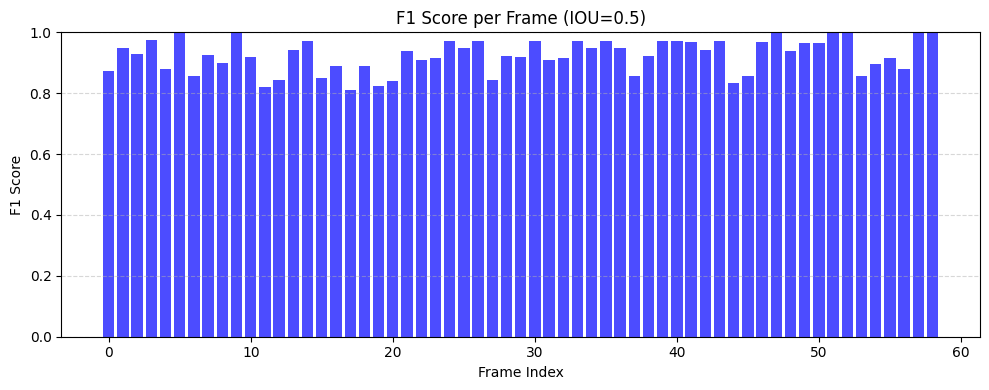

In [25]:
import os
import math
import matplotlib.pyplot as plt  # 用於畫圖

# =============== 工具函式 ===============
def parse_bboxes(txt_file_path):
    """
    將 txt 內的每行 'x,y,w,h' 讀成 (x, y, w, h) (int) 的列表
    若空檔或空行，則傳回空列表
    """
    bboxes = []
    if not os.path.isfile(txt_file_path):
        return bboxes
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) != 4:
                continue
            x, y, w, h = [int(float(val)) for val in parts]
            bboxes.append((x, y, w, h))
    return bboxes

def box_iou(boxA, boxB):
    """
    計算兩個 box 的 IOU，box 格式: (x, y, w, h)
    """
    xA, yA, wA, hA = boxA
    xB, yB, wB, hB = boxB

    inter_left   = max(xA, xB)
    inter_top    = max(yA, yB)
    inter_right  = min(xA + wA, xB + wB)
    inter_bottom = min(yA + hA, yB + hB)

    if inter_right <= inter_left or inter_bottom <= inter_top:
        return 0.0

    inter_area = (inter_right - inter_left) * (inter_bottom - inter_top)
    union_area = (wA * hA) + (wB * hB) - inter_area
    if union_area <= 0:
        return 0.0
    return inter_area / union_area

# =============== 主評估函式 ===============
def evaluate_detections(
    det_folder,         # 預測資料夾
    gt_folder,          # 真值資料夾
    iou_threshold=0.5   # 判定 TP 的 IOU 閾值
):
    """
    讀取 det_folder 與 gt_folder 內各對應檔案，計算整體 Precision、Recall、F1，
    並同時紀錄每個影格的 F1，以便後續畫圖。
    """
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # 用來記錄每個影格的 (tp_count, fp_count, fn_count)
    frame_stats = {}

    det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])

    for det_file in det_files:
        # e.g. det_file = "detections_00000.txt"
        file_id = det_file.replace("detections_", "")  # "00000.txt"
        file_id = file_id.replace(".txt", "")          # "00000"

        try:
            idx_int = int(file_id)
            # ground truth 對應的檔名 => 例如 "frame_0000.txt", 注意你的命名規則
            gt_id = f"{idx_int+1:04d}"  # 這邊 +1 (由你需要來決定是否要+1)
        except:
            continue

        gt_file = f"frame_{gt_id}.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)

        # 讀取
        det_bboxes = parse_bboxes(det_path)
        gt_bboxes  = parse_bboxes(gt_path)

        # 準備一個標記，用來表示哪些 gt_box 已配對
        used_gt = [False] * len(gt_bboxes)

        tp_count = 0
        fp_count = 0
        for det_box in det_bboxes:
            best_iou = 0
            best_gt_index = -1
            for i, gt_box in enumerate(gt_bboxes):
                if used_gt[i]:
                    continue
                iou_val = box_iou(det_box, gt_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_index = i
            
            if best_iou >= iou_threshold and best_gt_index != -1:
                tp_count += 1
                used_gt[best_gt_index] = True
            else:
                fp_count += 1

        fn_count = sum(1 for used in used_gt if not used)

        # 累計到總體
        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

        # ---------- 記錄該 frame 的統計 ----------
        frame_stats[idx_int] = (tp_count, fp_count, fn_count)

    # ---- 全部檔案處理完畢, 計算整體 precision / recall / F1 ----
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) else 0
    recall    = total_tp / (total_tp + total_fn) if (total_tp + total_fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # ---- 計算每影格的 F1, 用於後面畫圖 ----
    # 有時候某 frame 沒有偵測也沒有真值 (tp+fp=0, tp+fn=0)，可能會出現 0/0 => 視情況定義
    frame_f1_scores = {}
    for fid, (tp, fp, fn) in frame_stats.items():
        # 單影格 precision / recall / f1
        prec = tp / (tp + fp) if (tp + fp) else 0
        rec  = tp / (tp + fn) if (tp + fn) else 0
        f1_this = 2*prec*rec/(prec+rec) if (prec+rec) else 0
        frame_f1_scores[fid] = f1_this

    # ---- 簡易 mAP (此處無信心分數, 僅示範) ----
    ap  = precision
    mAP = ap

    return precision, recall, f1, mAP, frame_f1_scores

if __name__ == "__main__":
    base_dir = r"E:\論文\期刊\code\Detection_EXP\video2"

    det_folder = os.path.join(base_dir, "detections2")
    gt_folder  = os.path.join(base_dir, "ground_true_YOLO")

    iou_threshold = 0.5
    precision, recall, f1, mAP, frame_f1_scores = evaluate_detections(
        det_folder=det_folder,
        gt_folder=gt_folder,
        iou_threshold=iou_threshold
    )

    print(f"IOU Threshold: {iou_threshold}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"Simplified mAP: {mAP:.3f}")

    # ============= 繪製每影格的 F1 得分 =============
    # 這裡示範用 bar 或 line，都可以。
    # ------------------------------------------------
    # 將 frame_id 依排序後，拿到對應的 f1
    frame_ids_sorted = sorted(frame_f1_scores.keys())
    f1_values = [frame_f1_scores[fid] for fid in frame_ids_sorted]

    plt.figure(figsize=(10, 4))
    plt.bar(frame_ids_sorted, f1_values, color='blue', alpha=0.7)
    # 若想做折線圖，可改用 plt.plot(...) 代替
    # plt.plot(frame_ids_sorted, f1_values, marker='o', color='blue', alpha=0.7)

    plt.xlabel("Frame Index")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score per Frame (IOU={iou_threshold})")
    plt.ylim([0, 1])  # F1 Score 最多到 1
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


IOU Threshold: 0.5
Number of Frames Sampled (Total): 60
Random Seed: 895
Precision: 0.902
Recall:    0.944
F1 Score:  0.923
Simplified mAP: 0.902


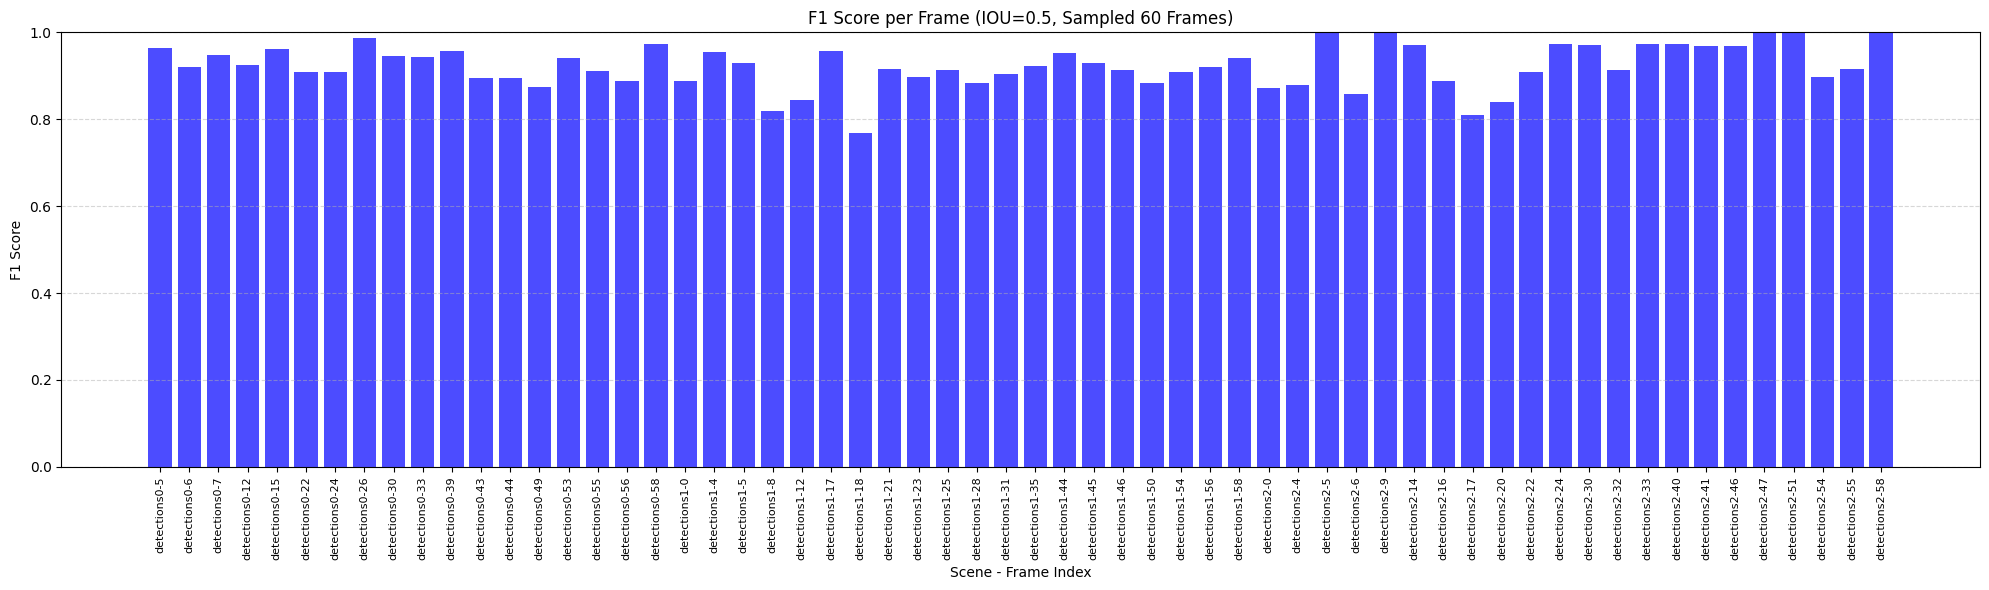

In [42]:
import os
import math
import matplotlib.pyplot as plt
import random

# =============== 工具函式 ===============
def parse_bboxes(txt_file_path):
    """
    將 txt 內的每行 'x,y,w,h' 讀成 (x, y, w, h) (int) 的列表
    若空檔或空行，則傳回空列表
    """
    bboxes = []
    if not os.path.isfile(txt_file_path):
        return bboxes
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) != 4:
                continue
            x, y, w, h = [int(float(val)) for val in parts]
            bboxes.append((x, y, w, h))
    return bboxes

def box_iou(boxA, boxB):
    """
    計算兩個 box 的 IOU，box 格式: (x, y, w, h)
    """
    xA, yA, wA, hA = boxA
    xB, yB, wB, hB = boxB

    inter_left   = max(xA, xB)
    inter_top    = max(yA, yB)
    inter_right  = min(xA + wA, xB + wB)
    inter_bottom = min(yA + hA, yB + hB)

    if inter_right <= inter_left or inter_bottom <= inter_top:
        return 0.0

    inter_area = (inter_right - inter_left) * (inter_bottom - inter_top)
    union_area = (wA * hA) + (wB * hB) - inter_area
    if union_area <= 0:
        return 0.0
    return inter_area / union_area

# =============== 主評估函式 ===============
def evaluate_detections(
    det_folders,         # 預測資料夾列表
    gt_folders,          # 真值資料夾列表
    iou_threshold=0.5,   # 判定 TP 的 IOU 閾值
    num_frames_to_sample=None, # 隨機抽取的影格總數，None 表示使用所有影格
    random_seed=None      # 隨機種子，用於重現性
):
    """
    讀取 det_folders 與 gt_folders 內各對應檔案，計算整體 Precision、Recall、F1，
    並同時紀錄每個影格的 F1，以便後續畫圖。
    可以選擇從所有影格中隨機抽取部分影格進行評估。
    """
    if len(det_folders) != len(gt_folders):
        raise ValueError("預測資料夾和真值資料夾的數量必須相同")

    all_frame_stats = {}
    all_det_files = []

    for i in range(len(det_folders)):
        det_folder = det_folders[i]
        gt_folder = gt_folders[i]
        det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])
        all_det_files.extend([(det_folder, f) for f in det_files])

    # 決定要評估哪些影格
    if num_frames_to_sample is not None:
        if random_seed is not None:
            random.seed(random_seed)
        sampled_det_files_info = random.sample(all_det_files, min(num_frames_to_sample, len(all_det_files)))
    else:
        sampled_det_files_info = all_det_files

    for det_folder, det_file in sampled_det_files_info:
        # e.g. det_file = "detections_00000.txt"
        file_id = det_file.replace("detections_", "")  # "00000.txt"
        file_id = file_id.replace(".txt", "")          # "00000"

        try:
            idx_int = int(file_id)
            # ground truth 對應的檔名 => 例如 "frame_0000.txt", 注意你的命名規則
            gt_id = f"{idx_int+1:04d}"  # 這邊 +1 (由你需要來決定是否要+1)
        except:
            continue

        gt_folder = gt_folders[det_folders.index(det_folder)]
        gt_file = f"frame_{gt_id}.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)

        # 讀取
        det_bboxes = parse_bboxes(det_path)
        gt_bboxes  = parse_bboxes(gt_path)

        # 準備一個標記，用來表示哪些 gt_box 已配對
        used_gt = [False] * len(gt_bboxes)

        tp_count = 0
        fp_count = 0
        for det_box in det_bboxes:
            best_iou = 0
            best_gt_index = -1
            for j, gt_box in enumerate(gt_bboxes):
                if used_gt[j]:
                    continue
                iou_val = box_iou(det_box, gt_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_index = j

            if best_iou >= iou_threshold and best_gt_index != -1:
                tp_count += 1
                used_gt[best_gt_index] = True
            else:
                fp_count += 1

        fn_count = sum(1 for used in used_gt if not used)

        # ---------- 記錄該 frame 的統計 ----------
        all_frame_stats[(det_folder, idx_int)] = (tp_count, fp_count, fn_count)

    # ---- 全部檔案處理完畢, 計算整體 precision / recall / F1 ----
    total_tp = sum(stats[0] for stats in all_frame_stats.values())
    total_fp = sum(stats[1] for stats in all_frame_stats.values())
    total_fn = sum(stats[2] for stats in all_frame_stats.values())

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) else 0
    recall    = total_tp / (total_tp + total_fn) if (total_tp + total_fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # ---- 計算每影格的 F1, 用於後面畫圖 ----
    # 有時候某 frame 沒有偵測也沒有真值 (tp+fp=0, tp+fn=0)，可能會出現 0/0 => 視情況定義
    frame_f1_scores = {}
    for (folder, fid), (tp, fp, fn) in all_frame_stats.items():
        # 單影格 precision / recall / f1
        prec = tp / (tp + fp) if (tp + fp) else 0
        rec  = tp / (tp + fn) if (tp + fn) else 0
        f1_this = 2 * prec * rec / (prec + rec) if (prec + rec) else 0
        frame_f1_scores[(folder, fid)] = f1_this

    # ---- 簡易 mAP (此處無信心分數, 僅示範) ----
    ap  = precision
    mAP = ap

    return precision, recall, f1, mAP, frame_f1_scores

if __name__ == "__main__":
    base_dir = r"E:\論文\期刊\code\Detection_EXP"

    det_folders = [
        os.path.join(base_dir, "video0", "detections0"),
        os.path.join(base_dir, "video1", "detections1"),
        os.path.join(base_dir, "video2", "detections2"),

    ]
    gt_folders = [
        os.path.join(base_dir, "video0", "ground_true_YOLO"),
        os.path.join(base_dir, "video1", "ground_true_YOLO"),
        os.path.join(base_dir, "video2", "ground_true_YOLO"),

    ]

    iou_threshold = 0.5
    num_frames_to_sample = 60
    import random
    random_seed =895 #設定隨機種子以獲得可重現的結果
   
    precision, recall, f1, mAP, frame_f1_scores = evaluate_detections(
        det_folders=det_folders,
        gt_folders=gt_folders,
        iou_threshold=iou_threshold,
        num_frames_to_sample=num_frames_to_sample,
        random_seed=random_seed
    )

    print(f"IOU Threshold: {iou_threshold}")
    print(f"Number of Frames Sampled (Total): {num_frames_to_sample}")
    print(f"Random Seed: {random_seed}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"Simplified mAP: {mAP:.3f}")

    # ============= 繪製每影格的 F1 得分 =============
    # ------------------------------------------------
    # 將 frame_id 依排序後，拿到對應的 f1
    frame_ids_sorted = sorted(frame_f1_scores.keys(), key=lambda x: (x[0], x[1])) # 先按資料夾排序，再按影格 ID 排序
    f1_values = [frame_f1_scores[fid] for fid in frame_ids_sorted]
    labels = [f"{fid[0].split(os.sep)[-1]}-{fid[1]}" for fid in frame_ids_sorted] # 顯示資料夾名稱和影格 ID

    plt.figure(figsize=(20, 6)) # 調整圖表大小以容納更多 bar
    plt.bar(labels, f1_values, color='blue', alpha=0.7)
    # 若想做折線圖，可改用 plt.plot(...) 代替
    # plt.plot(labels, f1_values, marker='o', color='blue', alpha=0.7)

    plt.xlabel("Scene - Frame Index")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score per Frame (IOU={iou_threshold}, Sampled {num_frames_to_sample} Frames)")
    plt.ylim([0, 1])  # F1 Score 最多到 1
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=90, fontsize=8) # 旋轉 x 軸標籤以便閱讀
    plt.tight_layout()
    plt.show()

IOU Threshold: 0.5
Precision: 0.163
Recall:    0.353
F1 Score:  0.223
AP:        0.233
Precision: 0.543
Recall:    0.671
F1 Score:  0.600
AP:        0.946
Precision: 0.917
Recall:    0.886
F1 Score:  0.901
AP:        0.972


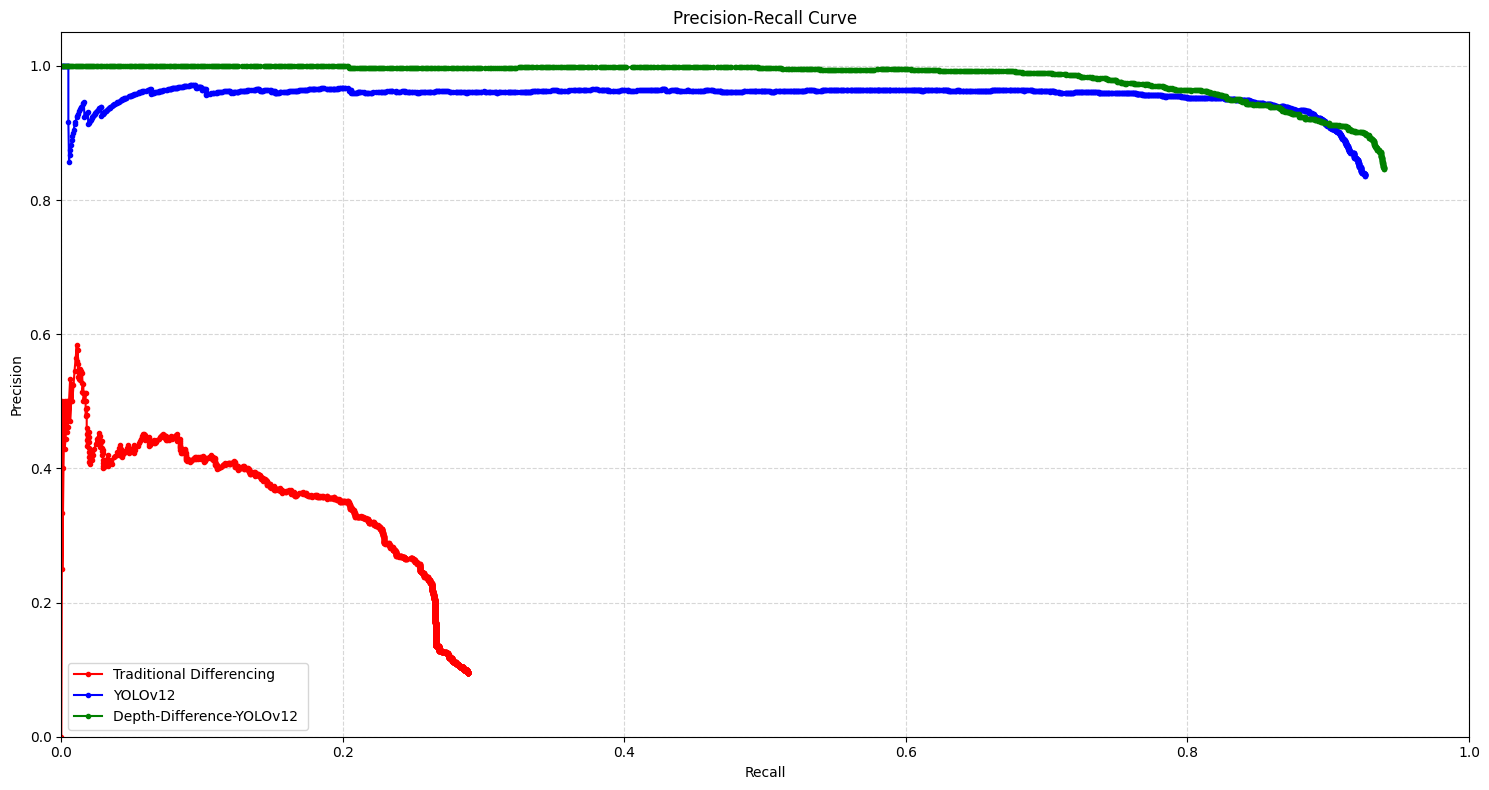

In [67]:
import os
import math
import matplotlib.pyplot as plt
import random

# =============== 工具函式 ===============
def parse_bboxes_with_conf(txt_file_path):
    """
    將 txt 內的每行 'x,y,w,h,conf' 讀成 (x, y, w, h, conf) 的列表
    若空檔或空行，則傳回空列表
    """
    bboxes = []
    if not os.path.isfile(txt_file_path):
        return bboxes
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            
            # 處理有信心分數的情況
            if len(parts) >= 5:
                x, y, w, h, conf = [float(val) for val in parts[:5]]
                bboxes.append((int(x), int(y), int(w), int(h), conf))
            else:
                # 相容舊格式
                x, y, w, h = [int(float(val)) for val in parts[:4]]
                bboxes.append((x, y, w, h, 1.0))  # 預設信心分數為 1.0
    return bboxes

def box_iou(boxA, boxB):
    """
    計算兩個 box 的 IOU，box 格式: (x, y, w, h) 或 (x, y, w, h, conf)
    """
    xA, yA, wA, hA = boxA[:4]
    xB, yB, wB, hB = boxB[:4]

    inter_left   = max(xA, xB)
    inter_top    = max(yA, yB)
    inter_right  = min(xA + wA, xB + wB)
    inter_bottom = min(yA + hA, yB + hB)

    if inter_right <= inter_left or inter_bottom <= inter_top:
        return 0.0

    inter_area = (inter_right - inter_left) * (inter_bottom - inter_top)
    union_area = (wA * hA) + (wB * hB) - inter_area
    if union_area <= 0:
        return 0.0
    return inter_area / union_area

def calculate_pr_curve(det_folder, gt_folder, iou_threshold=0.5):
    """
    計算 PR 曲線 (Precision-Recall Curve)，並計算 mAP。
    """
    all_detections = []
    all_gt_bboxes = []
    
    # 收集所有檔案中的預測和真實框
    det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])
    for det_file in det_files:
        file_id = det_file.replace("detections_", "").replace(".txt", "")
        try:
            idx_int = int(file_id)
            gt_id = f"{idx_int+1:04d}"
        except:
            continue
        
        gt_file = f"frame_{gt_id}.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)
        
        # 讀取偵測框和真實框
        det_bboxes = parse_bboxes_with_conf(det_path)
        gt_bboxes = parse_bboxes_with_conf(gt_path)
        
        all_detections.append((det_bboxes, gt_bboxes))

    # 遍歷不同的置信度閾值
    confidences = [det[4] for dets, _ in all_detections for det in dets if len(det) > 4]
    thresholds = sorted(set(confidences), reverse=True)
    
    recalls = []
    precisions = []
    total_tp = total_fp = total_fn = 0

    for threshold in thresholds:
        tp_count = 0
        fp_count = 0
        fn_count = 0

        for det_bboxes, gt_bboxes in all_detections:
            used_gt = [False] * len(gt_bboxes)

            # 根據置信度篩選偵測框
            filtered_det_bboxes = [box for box in det_bboxes if box[4] >= threshold]
            
            for det_box in filtered_det_bboxes:
                best_iou = 0
                best_gt_index = -1
                for i, gt_box in enumerate(gt_bboxes):
                    if used_gt[i]:
                        continue
                    iou_val = box_iou(det_box, gt_box)
                    if iou_val > best_iou:
                        best_iou = iou_val
                        best_gt_index = i
                
                if best_iou >= iou_threshold and best_gt_index != -1:
                    tp_count += 1
                    used_gt[best_gt_index] = True
                else:
                    fp_count += 1
            
            fn_count += sum(1 for used in used_gt if not used)

        # 計算 Precision 和 Recall
        precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) else 0
        recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) else 0
        
        precisions.append(precision)
        recalls.append(recall)

        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

    # 計算 mAP (Mean Average Precision)
    ap = sum(precisions) / len(precisions) if precisions else 0

    return recalls, precisions, ap

# =============== 主評估函式 ===============
def evaluate_detections(
    det_folders,         # 預測資料夾列表
    gt_folders,          # 真值資料夾列表
    iou_threshold=0.5,   # 判定 TP 的 IOU 閾值
    num_frames_to_sample=None, # 隨機抽取的影格總數，None 表示使用所有影格
    random_seed=None      # 隨機種子，用於重現性
):
    # Initialize total counts for true positives, false positives, and false negatives
    total_tp = 0
    total_fp = 0
    total_fn = 0
    # 用來記錄每個影格的 (tp_count, fp_count, fn_count)
    frame_stats = {}
    """
    讀取 det_folders 與 gt_folders 內各對應檔案，計算整體 Precision、Recall、F1，
    並同時紀錄每個影格的 F1，以便後續畫圖。
    可以選擇從所有影格中隨機抽取部分影格進行評估。
    """
    if len(det_folders) != len(gt_folders):
        raise ValueError("預測資料夾和真值資料夾的數量必須相同")

    all_det_files = []

    for i in range(len(det_folders)):
        det_folder = det_folders[i]
        gt_folder = gt_folders[i]
        det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])
        all_det_files.extend([(det_folder, f) for f in det_files])

    # 決定要評估哪些影格
    if num_frames_to_sample is not None:
        if random_seed is not None:
            random.seed(random_seed)
        sampled_det_files_info = random.sample(all_det_files, min(num_frames_to_sample, len(all_det_files)))
    else:
        sampled_det_files_info = all_det_files

    all_detections = []  # 將包含 (confidence, is_tp) 的列表
    for det_folder, det_file in sampled_det_files_info:
        # e.g. det_file = "detections_00000.txt"
        file_id = det_file.replace("detections_", "")  # "00000.txt"
        file_id = file_id.replace(".txt", "")          # "00000"

        try:
            idx_int = int(file_id)
            # ground truth 對應的檔名 => 例如 "frame_0000.txt", 注意你的命名規則
            gt_id = f"{idx_int+1:04d}"  # 這邊 +1 (由你需要來決定是否要+1)
        except:
            continue

        gt_folder = gt_folders[det_folders.index(det_folder)]
        gt_file = f"frame_{gt_id}.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)


        # 讀取 (現在有可能包含置信度)
        det_bboxes = parse_bboxes_with_conf(det_path)
        gt_bboxes = parse_bboxes_with_conf(gt_path)

        # 準備一個標記，用來表示哪些 gt_box 已配對
        used_gt = [False] * len(gt_bboxes)

        tp_count = 0
        fp_count = 0
        
        # 如果有置信度，先按照置信度從高到低排序
        if len(det_bboxes) > 0 and len(det_bboxes[0]) > 4:
            det_bboxes.sort(key=lambda x: x[4], reverse=True)
            
        for det_box in det_bboxes:
            best_iou = 0
            best_gt_index = -1
            for i, gt_box in enumerate(gt_bboxes):
                if used_gt[i]:
                    continue
                iou_val = box_iou(det_box, gt_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_index = i
            
            if best_iou >= iou_threshold and best_gt_index != -1:
                tp_count += 1
                used_gt[best_gt_index] = True
            else:
                fp_count += 1

        fn_count = sum(1 for used in used_gt if not used)

        # 累計到總體
        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

        # ---------- 記錄該 frame 的統計 ----------
        frame_stats[idx_int] = (tp_count, fp_count, fn_count)

    # ---- 全部檔案處理完畢, 計算整體 precision / recall / F1 ----
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) else 0
    recall    = total_tp / (total_tp + total_fn) if (total_tp + total_fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # ---- 計算每影格的 F1, 用於後面畫圖 ----
    # 有時候某 frame 沒有偵測也沒有真值 (tp+fp=0, tp+fn=0)，可能會出現 0/0 => 視情況定義
    frame_f1_scores = {}
    for fid, (tp, fp, fn) in frame_stats.items():
        # 單影格 precision / recall / f1
        prec = tp / (tp + fp) if (tp + fp) else 0
        rec  = tp / (tp + fn) if (tp + fn) else 0
        f1_this = 2*prec*rec/(prec+rec) if (prec+rec) else 0
        frame_f1_scores[fid] = f1_this

    # ---- 計算 PR 曲線 ----
    recalls, precisions, ap = calculate_pr_curve(det_folder, gt_folder, iou_threshold)
    mAP = ap

    return precision, recall, f1, mAP, frame_f1_scores, recalls, precisions


if __name__ == "__main__":
    base_dir = r"E:\論文\期刊\code\Detection_EXP"

    # 傳統差分法
    det_folders = [
        os.path.join(base_dir, "video0", "detections_T_conf"),
        os.path.join(base_dir, "video1", "detections_T_conf"),
        os.path.join(base_dir, "video2", "detections_T_conf"),
    ]
    gt_folders = [
        os.path.join(base_dir, "video0", "ground_true_YOLO"),
        os.path.join(base_dir, "video1", "ground_true_YOLO"),
        os.path.join(base_dir, "video2", "ground_true_YOLO"),
    ]
    iou_threshold = 0.5
    num_frames_to_sample = 60
    random_seed = 89  # 設定隨機種子以獲得可重現的結果

    precision0, recall0, f10, mAP0, frame_f1_scores0, pr_recalls, pr_precisions = evaluate_detections(
        det_folders=det_folders,
        gt_folders=gt_folders,
        iou_threshold=iou_threshold,
        num_frames_to_sample=num_frames_to_sample,
        random_seed=random_seed
    )

    # 只有YOLO
    det_folders = [
        os.path.join(base_dir, "video0", "detection_YOLO_conf"),
        os.path.join(base_dir, "video1", "detection_YOLO_conf"),
        os.path.join(base_dir, "video2", "detection_YOLO_conf"),
    ]
    gt_folders = [
        os.path.join(base_dir, "video0", "ground_true_YOLO"),
        os.path.join(base_dir, "video1", "ground_true_YOLO"),
        os.path.join(base_dir, "video2", "ground_true_YOLO"),
    ]
    precision1, recall1, f11, mAP1, frame_f1_scores1, pr_recalls_2, pr_precisions_2 = evaluate_detections(
        det_folders=det_folders,
        gt_folders=gt_folders,
        iou_threshold=iou_threshold,
        num_frames_to_sample=num_frames_to_sample,
        random_seed=random_seed
    )

    # YOLO+深度估計差分
    det_folders = [
        os.path.join(base_dir, "video0", "detections_conf"),
        os.path.join(base_dir, "video1", "detections_conf"),
        os.path.join(base_dir, "video2", "detections_conf"),
    ]
    gt_folders = [
        os.path.join(base_dir, "video0", "ground_true_YOLO"),
        os.path.join(base_dir, "video1", "ground_true_YOLO"),
        os.path.join(base_dir, "video2", "ground_true_YOLO"),
    ]
    precision2, recall2, f12, mAP2, frame_f1_scores2, pr_recalls_3, pr_precisions_3 = evaluate_detections(
        det_folders=det_folders,
        gt_folders=gt_folders,
        iou_threshold=iou_threshold,
        num_frames_to_sample=num_frames_to_sample,
        random_seed=random_seed
    )

    print(f"IOU Threshold: {iou_threshold}")
    print(f"Precision: {precision0:.3f}")
    print(f"Recall:    {recall0:.3f}")
    print(f"F1 Score:  {f10:.3f}")
    print(f"AP:        {mAP0:.3f}")

    print(f"Precision: {precision1:.3f}")
    print(f"Recall:    {recall1:.3f}")
    print(f"F1 Score:  {f11:.3f}")
    print(f"AP:        {mAP1:.3f}")

    print(f"Precision: {precision2:.3f}")
    print(f"Recall:    {recall2:.3f}")
    print(f"F1 Score:  {f12:.3f}")
    print(f"AP:        {mAP2:.3f}")

    # ============= 繪製三個 PR 曲線 =============

    plt.figure(figsize=(15, 8))

    # PR 曲線1: 傳統差分法
    plt.plot(pr_recalls, pr_precisions, marker='.', linestyle='-', color='red', label='Traditional Differencing')

    # PR 曲線2: 只有 YOLO
    plt.plot(pr_recalls_2, pr_precisions_2, marker='.', linestyle='-', color='blue', label='YOLOv12')

    # PR 曲線3: YOLO + 深度估計差分
    plt.plot(pr_recalls_3, pr_precisions_3, marker='.', linestyle='-', color='green', label='Depth-Difference-YOLOv12 ')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

# PR curve

IOU Threshold: 0.5
Precision: 0.871
Recall:    0.972
F1 Score:  0.919
AP:        0.943


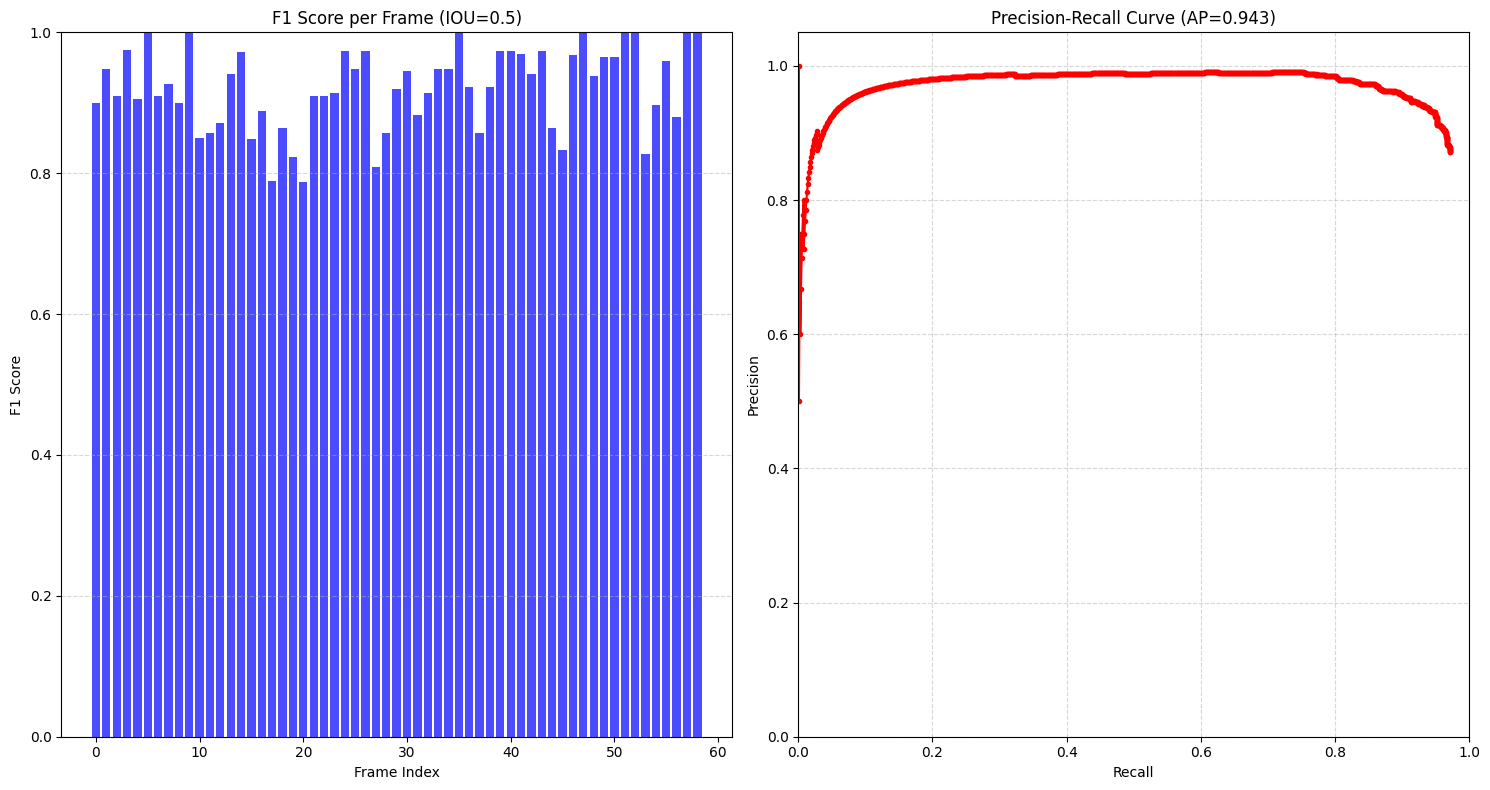

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# =============== 工具函式 ===============
def parse_bboxes_with_conf(txt_file_path):
    """
    將 txt 內的每行 'x,y,w,h,conf' 讀成 (x, y, w, h, conf) 的列表
    若空檔或空行，則傳回空列表
    """
    bboxes = []
    if not os.path.isfile(txt_file_path):
        return bboxes
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            
            # 處理有信心分數的情況
            if len(parts) >= 5:
                x, y, w, h, conf = [float(val) for val in parts[:5]]
                bboxes.append((int(x), int(y), int(w), int(h), conf))
            else:
                # 相容舊格式
                x, y, w, h = [int(float(val)) for val in parts[:4]]
                bboxes.append((x, y, w, h, 1.0))  # 預設信心分數為 1.0
    return bboxes

def box_iou(boxA, boxB):
    """
    計算兩個 box 的 IOU，box 格式: (x, y, w, h) 或 (x, y, w, h, conf)
    """
    xA, yA, wA, hA = boxA[:4]
    xB, yB, wB, hB = boxB[:4]

    inter_left   = max(xA, xB)
    inter_top    = max(yA, yB)
    inter_right  = min(xA + wA, xB + wB)
    inter_bottom = min(yA + hA, yB + hB)

    if inter_right <= inter_left or inter_bottom <= inter_top:
        return 0.0

    inter_area = (inter_right - inter_left) * (inter_bottom - inter_top)
    union_area = (wA * hA) + (wB * hB) - inter_area
    if union_area <= 0:
        return 0.0
    return inter_area / union_area

# =============== PR曲線計算函式 ===============
def calculate_pr_curve(det_folder, gt_folder, iou_threshold=0.5):
    """
    計算整個資料集的PR曲線
    """
    # 收集所有偵測結果
    all_detections = []  # 將包含 (confidence, is_tp) 的列表
    total_gt_count = 0   # 總共有多少 ground truth boxes
    
    det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])

    for det_file in det_files:
        # e.g. det_file = "detections_00000.txt"
        file_id = det_file.replace("detections_", "")  # "00000.txt"
        file_id = file_id.replace(".txt", "")          # "00000"

        try:
            idx_int = int(file_id)
            # ground truth 對應的檔名 => 例如 "frame_0000.txt", 注意你的命名規則
            gt_id = f"{idx_int+1:04d}"  # 這邊 +1 (由你需要來決定是否要+1)
        except:
            continue

        gt_file = f"frame_{gt_id}.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)

        # 讀取 (現在包含置信度)
        det_bboxes = parse_bboxes_with_conf(det_path)
        gt_bboxes = parse_bboxes_with_conf(gt_path)
        
        # 增加 ground truth 的總數
        total_gt_count += len(gt_bboxes)
        
        # 準備一個標記，用來表示哪些 gt_box 已配對
        used_gt = [False] * len(gt_bboxes)

        # 先按照置信度從高到低排序
        det_bboxes.sort(key=lambda x: x[4], reverse=True)
        
        # 處理每個偵測結果
        for det_box in det_bboxes:
            conf = det_box[4]
            is_tp = False
            
            best_iou = 0
            best_gt_index = -1
            for i, gt_box in enumerate(gt_bboxes):
                if used_gt[i]:
                    continue
                iou_val = box_iou(det_box, gt_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_index = i
            
            if best_iou >= iou_threshold and best_gt_index != -1:
                is_tp = True
                used_gt[best_gt_index] = True
            
            all_detections.append((conf, is_tp))
    
    # 按照置信度從高到低排序所有偵測結果
    all_detections.sort(key=lambda x: x[0], reverse=True)
    
    # 計算累計的 TP 和 FP
    cumulative_tp = 0
    cumulative_fp = 0
    precisions = []
    recalls = []
    
    # 從置信度高到低處理，計算每個置信度閾值下的 precision 和 recall
    for conf, is_tp in all_detections:
        if is_tp:
            cumulative_tp += 1
        else:
            cumulative_fp += 1
        
        precision = cumulative_tp / (cumulative_tp + cumulative_fp) if (cumulative_tp + cumulative_fp) > 0 else 0
        recall = cumulative_tp / total_gt_count if total_gt_count > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    # 確保PR曲線有點 (0,1) 和 (1,0)
    if not precisions:
        precisions = [0]
        recalls = [0]
    
    # 計算 AP (近似積分)
    AP = 0
    for i in range(len(recalls)-1):
        AP += (recalls[i+1] - recalls[i]) * precisions[i+1]
    
    return recalls, precisions, AP

# =============== 主評估函式 ===============
def evaluate_detections(
    det_folder,         # 預測資料夾
    gt_folder,          # 真值資料夾
    iou_threshold=0.5   # 判定 TP 的 IOU 閾值
):
    """
    讀取 det_folder 與 gt_folder 內各對應檔案，計算整體 Precision、Recall、F1，
    並同時紀錄每個影格的 F1，以便後續畫圖。
    """
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # 用來記錄每個影格的 (tp_count, fp_count, fn_count)
    frame_stats = {}

    det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])

    for det_file in det_files:
        # e.g. det_file = "detections_00000.txt"
        file_id = det_file.replace("detections_", "")  # "00000.txt"
        file_id = file_id.replace(".txt", "")          # "00000"

        try:
            idx_int = int(file_id)
            # ground truth 對應的檔名 => 例如 "frame_0000.txt", 注意你的命名規則
            gt_id = f"{idx_int+1:04d}"  # 這邊 +1 (由你需要來決定是否要+1)
        except:
            continue

        gt_file = f"frame_{gt_id}.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)

        # 讀取 (現在有可能包含置信度)
        det_bboxes = parse_bboxes_with_conf(det_path)
        gt_bboxes = parse_bboxes_with_conf(gt_path)

        # 準備一個標記，用來表示哪些 gt_box 已配對
        used_gt = [False] * len(gt_bboxes)

        tp_count = 0
        fp_count = 0
        
        # 如果有置信度，先按照置信度從高到低排序
        if len(det_bboxes) > 0 and len(det_bboxes[0]) > 4:
            det_bboxes.sort(key=lambda x: x[4], reverse=True)
            
        for det_box in det_bboxes:
            best_iou = 0
            best_gt_index = -1
            for i, gt_box in enumerate(gt_bboxes):
                if used_gt[i]:
                    continue
                iou_val = box_iou(det_box, gt_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_index = i
            
            if best_iou >= iou_threshold and best_gt_index != -1:
                tp_count += 1
                used_gt[best_gt_index] = True
            else:
                fp_count += 1

        fn_count = sum(1 for used in used_gt if not used)

        # 累計到總體
        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

        # ---------- 記錄該 frame 的統計 ----------
        frame_stats[idx_int] = (tp_count, fp_count, fn_count)

    # ---- 全部檔案處理完畢, 計算整體 precision / recall / F1 ----
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) else 0
    recall    = total_tp / (total_tp + total_fn) if (total_tp + total_fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # ---- 計算每影格的 F1, 用於後面畫圖 ----
    # 有時候某 frame 沒有偵測也沒有真值 (tp+fp=0, tp+fn=0)，可能會出現 0/0 => 視情況定義
    frame_f1_scores = {}
    for fid, (tp, fp, fn) in frame_stats.items():
        # 單影格 precision / recall / f1
        prec = tp / (tp + fp) if (tp + fp) else 0
        rec  = tp / (tp + fn) if (tp + fn) else 0
        f1_this = 2*prec*rec/(prec+rec) if (prec+rec) else 0
        frame_f1_scores[fid] = f1_this

    # ---- 計算 PR 曲線 ----
    recalls, precisions, ap = calculate_pr_curve(det_folder, gt_folder, iou_threshold)
    mAP = ap

    return precision, recall, f1, mAP, frame_f1_scores, recalls, precisions

if __name__ == "__main__":
    base_dir = r"E:\論文\期刊\code\Detection_EXP\video2"

    det_folder = os.path.join(base_dir, "detections_conf")
    gt_folder  = os.path.join(base_dir, "ground_true_YOLO")

    iou_threshold = 0.5
    precision, recall, f1, mAP, frame_f1_scores, pr_recalls, pr_precisions = evaluate_detections(
        det_folder=det_folder,
        gt_folder=gt_folder,
        iou_threshold=iou_threshold
    )

    print(f"IOU Threshold: {iou_threshold}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"AP:        {mAP:.3f}")

    # ============= 繪製每影格的 F1 得分 =============
    plt.figure(figsize=(15, 8))
    
    # 子圖1: 每個影格的 F1 得分
    plt.subplot(1, 2, 1)
    frame_ids_sorted = sorted(frame_f1_scores.keys())
    f1_values = [frame_f1_scores[fid] for fid in frame_ids_sorted]

    plt.bar(frame_ids_sorted, f1_values, color='blue', alpha=0.7)
    # 若想做折線圖，可改用 plt.plot(...) 代替
    # plt.plot(frame_ids_sorted, f1_values, marker='o', color='blue', alpha=0.7)

    plt.xlabel("Frame Index")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score per Frame (IOU={iou_threshold})")
    plt.ylim([0, 1])  # F1 Score 最多到 1
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    # 子圖2: PR 曲線
    plt.subplot(1, 2, 2)
    plt.plot(pr_recalls, pr_precisions, marker='.', linestyle='-', color='red')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve (AP={mAP:.3f})")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()

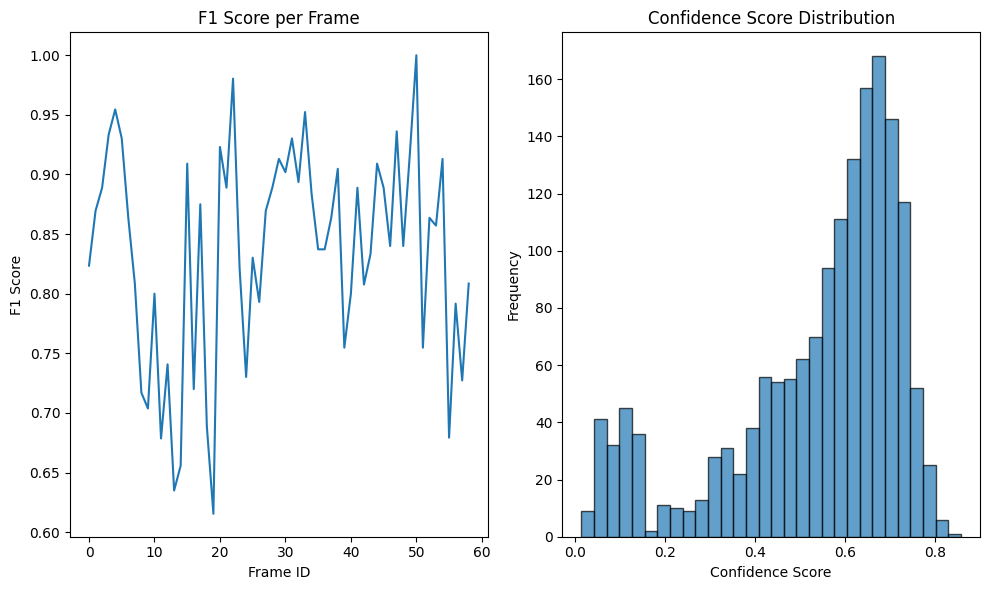

IOU Threshold: 0.5
Precision: 0.871
Recall:    0.972
F1 Score:  0.919
AP:        0.943


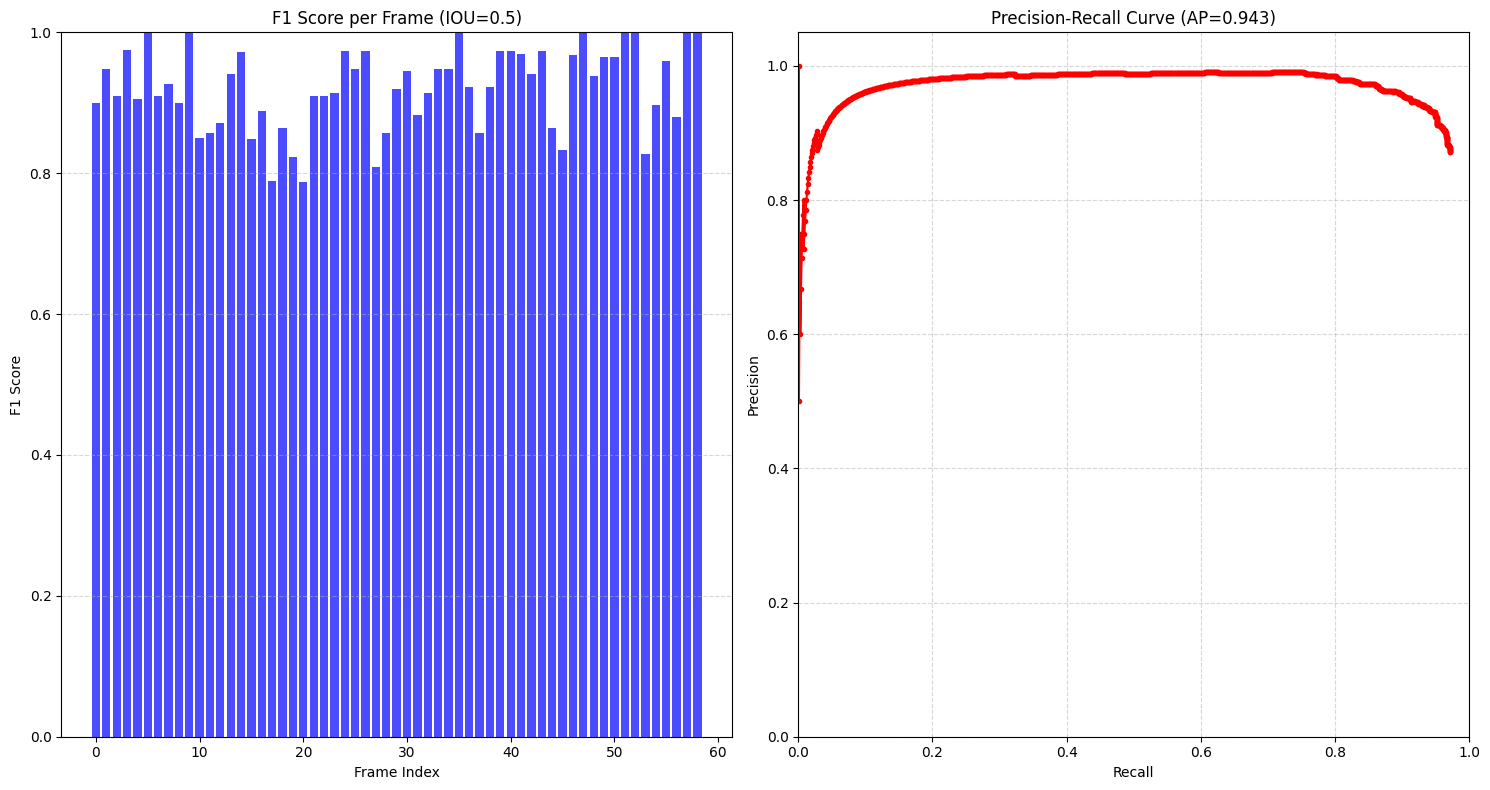

In [41]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# =============== 工具函式 ===============
def parse_bboxes_with_conf(txt_file_path):
    """
    將 txt 內的每行 'x,y,w,h,conf' 讀成 (x, y, w, h, conf) 的列表
    若空檔或空行，則傳回空列表
    """
    bboxes = []
    if not os.path.isfile(txt_file_path):
        return bboxes
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            
            # 處理有信心分數的情況
            if len(parts) >= 5:
                x, y, w, h, conf = [float(val) for val in parts[:5]]
                bboxes.append((int(x), int(y), int(w), int(h), conf))
            else:
                # 相容舊格式
                x, y, w, h = [int(float(val)) for val in parts[:4]]
                bboxes.append((x, y, w, h, 1.0))  # 預設信心分數為 1.0
    return bboxes

def box_iou(boxA, boxB):
    """
    計算兩個 box 的 IOU，box 格式: (x, y, w, h) 或 (x, y, w, h, conf)
    """
    xA, yA, wA, hA = boxA[:4]
    xB, yB, wB, hB = boxB[:4]

    inter_left   = max(xA, xB)
    inter_top    = max(yA, yB)
    inter_right  = min(xA + wA, xB + wB)
    inter_bottom = min(yA + hA, yB + hB)

    if inter_right <= inter_left or inter_bottom <= inter_top:
        return 0.0

    inter_area = (inter_right - inter_left) * (inter_bottom - inter_top)
    union_area = (wA * hA) + (wB * hB) - inter_area
    if union_area <= 0:
        return 0.0
    return inter_area / union_area

# =============== PR曲線計算函式 ===============
def calculate_pr_curve(det_folder, gt_folder, iou_threshold=0.5):
    """
    計算整個資料集的PR曲線
    """
    # 收集所有偵測結果
    all_detections = []  # 將包含 (confidence, is_tp) 的列表
    total_gt_count = 0   # 總共有多少 ground truth boxes
    
    det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])

    for det_file in det_files:
        # e.g. det_file = "detections_00000.txt"
        file_id = det_file.replace("detections_", "")  # "00000.txt"
        file_id = file_id.replace(".txt", "")          # "00000"

        try:
            idx_int = int(file_id)
            # ground truth 對應的檔名 => 例如 "frame_0000.txt", 注意你的命名規則
            gt_id = f"{idx_int+1:04d}"  # 這邊 +1 (由你需要來決定是否要+1)
        except:
            continue

        gt_file = f"frame_{gt_id}.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)

        # 讀取 (現在包含置信度)
        det_bboxes = parse_bboxes_with_conf(det_path)
        gt_bboxes = parse_bboxes_with_conf(gt_path)
        
        # 增加 ground truth 的總數
        total_gt_count += len(gt_bboxes)
        
        # 準備一個標記，用來表示哪些 gt_box 已配對
        used_gt = [False] * len(gt_bboxes)

        # 先按照置信度從高到低排序
        det_bboxes.sort(key=lambda x: x[4], reverse=True)
        
        # 處理每個偵測結果
        for det_box in det_bboxes:
            conf = det_box[4]
            is_tp = False
            
            best_iou = 0
            best_gt_index = -1
            for i, gt_box in enumerate(gt_bboxes):
                if used_gt[i]:
                    continue
                iou_val = box_iou(det_box, gt_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_index = i
            
            if best_iou >= iou_threshold and best_gt_index != -1:
                is_tp = True
                used_gt[best_gt_index] = True
            
            all_detections.append((conf, is_tp))
    
    # 按照置信度從高到低排序所有偵測結果
    all_detections.sort(key=lambda x: x[0], reverse=True)
    
    # 計算累計的 TP 和 FP
    cumulative_tp = 0
    cumulative_fp = 0
    precisions = []
    recalls = []
    
    # 從置信度高到低處理，計算每個置信度閾值下的 precision 和 recall
    for conf, is_tp in all_detections:
        if is_tp:
            cumulative_tp += 1
        else:
            cumulative_fp += 1
        
        precision = cumulative_tp / (cumulative_tp + cumulative_fp) if (cumulative_tp + cumulative_fp) > 0 else 0
        recall = cumulative_tp / total_gt_count if total_gt_count > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    # 確保PR曲線有點 (0,1) 和 (1,0)
    if not precisions:
        precisions = [0]
        recalls = [0]
    
    # 計算 AP (近似積分)
    AP = 0
    for i in range(len(recalls)-1):
        AP += (recalls[i+1] - recalls[i]) * precisions[i+1]
    
    return recalls, precisions, AP

# =============== 主評估函式 ===============
def evaluate_detections(
    det_folder,         # 預測資料夾
    gt_folder,          # 真值資料夾
    iou_threshold=0.5   # 判定 TP 的 IOU 閾值
):
    """
    讀取 det_folder 與 gt_folder 內各對應檔案，計算整體 Precision、Recall、F1，
    並同時紀錄每個影格的 F1，以便後續畫圖。
    """
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # 用來記錄每個影格的 (tp_count, fp_count, fn_count)
    frame_stats = {}

    det_files = sorted([f for f in os.listdir(det_folder) if f.endswith('.txt')])

    for det_file in det_files:
        # e.g. det_file = "detections_00000.txt"
        file_id = det_file.replace("detections_", "")  # "00000.txt"
        file_id = file_id.replace(".txt", "")          # "00000"

        try:
            idx_int = int(file_id)
            # ground truth 對應的檔名 => 例如 "frame_0000.txt", 注意你的命名規則
            gt_id = f"{idx_int+1:04d}"  # 這邊 +1 (由你需要來決定是否要+1)
        except:
            continue

        gt_file = f"frame_{gt_id}.txt"
        gt_path = os.path.join(gt_folder, gt_file)
        det_path = os.path.join(det_folder, det_file)

        # 讀取 (現在有可能包含置信度)
        det_bboxes = parse_bboxes_with_conf(det_path)
        gt_bboxes = parse_bboxes_with_conf(gt_path)

        # 準備一個標記，用來表示哪些 gt_box 已配對
        used_gt = [False] * len(gt_bboxes)

        tp_count = 0
        fp_count = 0
        
        # 如果有置信度，先按照置信度從高到低排序
        if len(det_bboxes) > 0 and len(det_bboxes[0]) > 4:
            det_bboxes.sort(key=lambda x: x[4], reverse=True)
            
        for det_box in det_bboxes:
            best_iou = 0
            best_gt_index = -1
            for i, gt_box in enumerate(gt_bboxes):
                if used_gt[i]:
                    continue
                iou_val = box_iou(det_box, gt_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_index = i
            
            if best_iou >= iou_threshold and best_gt_index != -1:
                tp_count += 1
                used_gt[best_gt_index] = True
            else:
                fp_count += 1

        fn_count = sum(1 for used in used_gt if not used)

        # 累計到總體
        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

        # ---------- 記錄該 frame 的統計 ----------
        frame_stats[idx_int] = (tp_count, fp_count, fn_count)

    # ---- 全部檔案處理完畢, 計算整體 precision / recall / F1 ----
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) else 0
    recall    = total_tp / (total_tp + total_fn) if (total_tp + total_fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # ---- 計算每影格的 F1, 用於後面畫圖 ----
    # 有時候某 frame 沒有偵測也沒有真值 (tp+fp=0, tp+fn=0)，可能會出現 0/0 => 視情況定義
    frame_f1_scores = {}
    for fid, (tp, fp, fn) in frame_stats.items():
        # 單影格 precision / recall / f1
        prec = tp / (tp + fp) if (tp + fp) else 0
        rec  = tp / (tp + fn) if (tp + fn) else 0
        f1_this = 2*prec*rec/(prec+rec) if (prec+rec) else 0
        frame_f1_scores[fid] = f1_this

    # ---- 計算 PR 曲線 ----
    recalls, precisions, ap = calculate_pr_curve(det_folder, gt_folder, iou_threshold)
    mAP = ap

    return precision, recall, f1, mAP, frame_f1_scores, recalls, precisions

if __name__ == "__main__":
    base_dir = r"E:\論文\期刊\code\Detection_EXP\video2"

    det_folder = os.path.join(base_dir, "detections_conf")
    gt_folder  = os.path.join(base_dir, "ground_true_YOLO")

    iou_threshold = 0.5
    precision, recall, f1, mAP, frame_f1_scores, pr_recalls, pr_precisions = evaluate_detections(
        det_folder=det_folder,
        gt_folder=gt_folder,
        iou_threshold=iou_threshold
    )

    print(f"IOU Threshold: {iou_threshold}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"AP:        {mAP:.3f}")

    # ============= 繪製每影格的 F1 得分 =============
    plt.figure(figsize=(15, 8))
    
    # 子圖1: 每個影格的 F1 得分
    plt.subplot(1, 2, 1)
    frame_ids_sorted = sorted(frame_f1_scores.keys())
    f1_values = [frame_f1_scores[fid] for fid in frame_ids_sorted]

    plt.bar(frame_ids_sorted, f1_values, color='blue', alpha=0.7)
    # 若想做折線圖，可改用 plt.plot(...) 代替
    # plt.plot(frame_ids_sorted, f1_values, marker='o', color='blue', alpha=0.7)

    plt.xlabel("Frame Index")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score per Frame (IOU={iou_threshold})")
    plt.ylim([0, 1])  # F1 Score 最多到 1
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    # 子圖2: PR 曲線
    plt.subplot(1, 2, 2)
    plt.plot(pr_recalls, pr_precisions, marker='.', linestyle='-', color='red')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve (AP={mAP:.3f})")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()